# Predicting NBA Game Outcomes from Historical Season Data (2023-2024)

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as ols
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [4]:
# Import data
df = pd.read_excel('Dataset.xlsx')
df.head()

,Team,Match Up,Game Date,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
0,GSW,GSW vs. PHX,10/24/2023,L,240,104,36,101,35.6,10,...,78.6,18,31,49,19,11,6,11,23,-4
1,PHX,PHX @ GSW,10/24/2023,W,240,108,42,95,44.2,11,...,76.5,17,43,60,23,5,7,19,22,4
2,LAL,LAL @ DEN,10/24/2023,L,240,107,41,90,45.6,10,...,75,13,31,44,23,5,4,12,18,-12
3,DEN,DEN vs. LAL,10/24/2023,W,240,119,48,91,52.7,14,...,75,9,33,42,29,9,6,12,15,12
4,MEM,MEM vs. NOP,10/25/2023,L,240,104,38,91,41.8,12,...,80,8,29,37,23,8,7,13,19,-7


### Feature Engineering

Basketball Statistics

In [5]:
# Preprocess the data
df['Game Date'] = pd.to_datetime(df['Game Date'], format='%m/%d/%Y')
df['FT%'] = pd.to_numeric(df['FT%'], errors='coerce')
df['Home Advantage'] = df['Match Up'].apply(lambda x: 1 if "vs." in x else 0)
df['Win'] = df['W/L'].apply(lambda x: 1 if x == 'W' else 0)

# Win Streak
# explanation of code: https://joshdevlin.com/blog/calculate-streaks-in-pandas/
# note: adjusted since there was previously an indexing issue
win_streak = df.groupby('Team')['Win'].apply(lambda x: x * (x.groupby((x != x.shift()).cumsum()).cumcount()))
# note: we do not add 1 to cumcount(), otherwise it will count current game as a win
win_streak_ind = win_streak.index.get_level_values(1)

df.loc[win_streak_ind, 'Win_Streak'] = np.array(win_streak)

# True Shooting Percentage: PTS / [ 2 * (FGA + 0.44*FTA) ]
# more info: https://en.wikipedia.org/wiki/True_shooting_percentage
df['TS%'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA'] + 1e-9))

def find_opponent_team(df):
    opponent_team = []

     # Iterate over each game
    for index, row in df.iterrows():
        # Identify opponent team and their stats
        matchup = row['Match Up']
        opponent = matchup.split(' ')[-1]  # Extract the opponent team abbreviation

        opponent_team.append(opponent)

    df['Opponent Team'] = opponent_team
    return df

df = find_opponent_team(df)

# Function to calculate opponent DREB
def calculate_opponent_dreb(df):
    # initialize object for Opponent DREB
    opponent_dreb = []

    # Iterate over each game
    for index, row in df.iterrows():

        # Find the opponent team's row in the dataset for the same game
        opponent_row = df[(df['Team'] == row['Opponent Team']) & (df['Game Date'] == row['Game Date'])]

        if not opponent_row.empty:
            # Opponent's DREB is this team's DREB
            opponent_dreb.append(opponent_row.iloc[0]['DREB'])
        else:
            # Append NaN if opponent data is not found
            opponent_dreb.append(None)

    # Add the calculated opponent DREB to the dataframe
    df['Opponent_DREB'] = opponent_dreb
    return df

# Apply the function to the dataset
df = calculate_opponent_dreb(df)


# Function to calculate opponent's OREB (Offensive Rebounds)
def calculate_opponent_oreb(df):

    # initialize object for Opponent OREB
    opponent_oreb = []

    for index, row in df.iterrows():

        # Find the opponent's row in the dataset for the same game
        opponent_row = df[(df['Team'] == row['Opponent Team']) & (df['Game Date'] == row['Game Date'])]

        if not opponent_row.empty:
            # Opponent's OREB is this team's DREB
            opponent_oreb.append(opponent_row.iloc[0]['OREB'])
        else:
            # Append NaN if opponent data is not found
            opponent_oreb.append(None)

    # Add the calculated opponent OREB to the dataframe
    df['Opponent_OREB'] = opponent_oreb
    return df

# Apply the function to your dataset
df = calculate_opponent_oreb(df)

# Effective Field Goal Percentage: eFG% = (FGM + 0.5 * 3PM) / FGA
df['eFG%'] = (df['FGM'] + 0.5 * df['3PM']) / (df['FGA'] + 1e-9)

# Assist Percentage: AST% = AST / FGM
df['AST%'] = df['AST'] / (df['FGM'] + 1e-9)

# Turnover Percentage: TOV% = TOV / (FGA + 0.44 * FTA + TOV)
df['TOV%'] = df['TOV'] / (df['FGA'] + 0.44 * df['FTA'] + df['TOV'])

# Offensive Rebound Percentage: OREB% = OREB / (OREB + Opponent_DREB)
df['OREB%'] = df['OREB'] / (df['OREB'] + df['Opponent_DREB'] + 1e-9)

# Offensive Rebound Percentage: DREB% = DREB / (DREB + Opponent_OREB)
df['DREB%'] = df['DREB'] / (df['DREB'] + df['Opponent_OREB'] + 1e-9)

# Possessions: POSS = FGA - OREB + TO + (0.475*FTA)
df['POSS'] = df["FGA"] - df['OREB'] + df["TOV"] + (0.475*df["FTA"])

Rolling Averages

In [6]:
# Rolling averages: https://datagy.io/rolling-average-pandas/
features = ['+/-', 'TS%', 'eFG%', 'PF', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'AST%', 'TOV%', 'OREB', 'DREB', 'REB', 'OREB%', 'DREB%', 'POSS']
window_size = 10
for feature in features:
    df[f'AVG_{feature}']= df.groupby('Team')[feature].transform(lambda x: x.rolling(window = window_size, min_periods = window_size, closed = 'left').mean())
df.head()

,Team,Match Up,Game Date,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,AVG_FTA,AVG_FT%,AVG_AST%,AVG_TOV%,AVG_OREB,AVG_DREB,AVG_REB,AVG_OREB%,AVG_DREB%,AVG_POSS
0,GSW,GSW vs. PHX,2023-10-24,L,240,104,36,101,35.6,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PHX,PHX @ GSW,2023-10-24,W,240,108,42,95,44.2,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LAL,LAL @ DEN,2023-10-24,L,240,107,41,90,45.6,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEN,DEN vs. LAL,2023-10-24,W,240,119,48,91,52.7,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MEM,MEM vs. NOP,2023-10-25,L,240,104,38,91,41.8,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ELO Ratings

In [ ]:
# Convert Game Date to datetime
df['Game Date'] = pd.to_datetime(df['Game Date'])

# Initialize Elo ratings for all teams (using 1500 as starting Elo rating)
elo_ratings = {team: 1500 for team in df['Team'].unique()}
baseline_elo = 1505  # Elo rating at the beginning of the next season
K_constant = 20  # K constant for Elo rating updates

# Function to calculate expected outcome (E)
def expected_outcome(elo_a, elo_b):
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

# Add columns for Elo ratings
df['Team Elo'] = 0
df['Opponent Elo'] = 0

# Process games row by row
for idx, row in df.iterrows():
    team = row['Team']
    opponent = row['Match Up'].split(' vs. ')[1] if 'vs.' in row['Match Up'] else row['Match Up'].split(' @ ')[1]

    # Get current Elo ratings
    team_elo = elo_ratings[team]
    opponent_elo = elo_ratings[opponent]

    # Calculate expected outcome (E)
    E_team = expected_outcome(team_elo, opponent_elo)
    E_opponent = 1 - E_team

    # Actual outcome (S)
    S_team = 1 if row['W/L'] == 'W' else 0
    S_opponent = 1 - S_team

    # Calculate margin of victory (MOV) and Elo difference (ED)
    MOV = abs(df.loc[(df['Team'] == team) & (df['Match Up'].str.contains(opponent)),'PTS'].values[0] -
              df.loc[(df['Team'] == opponent) & (df['Match Up'].str.contains(team)),'PTS'].values[0])
    ED = abs(team_elo - opponent_elo)

    # Calculate dynamic K
    K = (K_constant * (MOV + 3) ** 0.8) / (7.5 + 0.006 * ED)

    # Update Elo ratings using the formula
    new_team_elo = team_elo + K * (S_team - E_team)
    new_opponent_elo = opponent_elo + K * (S_opponent - E_opponent)

    # Update Elo ratings dictionary
    elo_ratings[team] = new_team_elo
    elo_ratings[opponent] = new_opponent_elo

    # Store updated ratings in DataFrame
    df.at[idx, 'Team Elo'] = round(new_team_elo, 1)
    df.at[idx, 'Opponent Elo'] = round(new_opponent_elo, 1)

# Adjust Elo rating for the next season (for all teams)
for team in elo_ratings:
    elo_ratings[team] = (elo_ratings[team] * 0.75) + (0.25 * baseline_elo)

# Display updated Elo ratings
df[['Team', 'Match Up', 'Team Elo', 'Opponent Elo']].head(20)

Previous Matchups

In [8]:
# Previous competition feature, same match up

matchup_wins = {}
for idx, row in df.iterrows():
    teams = sorted(row["Match Up"].split(" vs. ") if "vs." in row["Match Up"] else row["Match Up"].split(" @ "))
    matchup = tuple(teams)

    winner = row["Team"] if row["Win"] == 1 else teams[1] if row["Team"] == teams[0] else teams[0]

    if matchup in matchup_wins:
        previous_wins = [
            win_date
            for win_date, win_team in matchup_wins[matchup]
            if win_date < row["Game Date"]
        ]
        df.loc[idx, "Prev Matchup Wins"] = len(
            [win_team for win_date, win_team in matchup_wins[matchup] if win_team == winner and win_date < row["Game Date"]]
        )
    else:
        df.loc[idx, "Prev Matchup Wins"] = 0

    if matchup not in matchup_wins:
        matchup_wins[matchup] = []
    matchup_wins[matchup].append((row["Game Date"], winner))

matchup_losses = {}
for idx, row in df.iterrows():
    teams = sorted(row["Match Up"].split(" vs. ") if "vs." in row["Match Up"] else row["Match Up"].split(" @ "))
    matchup = tuple(teams)

    loser = teams[1] if row["Team"] == teams[0] and row["Win"] == 0 else teams[0] if row["Team"] == teams[1] and row["Win"] == 0 else None

    if matchup in matchup_losses and loser:
        df.loc[idx, "Prev Matchup Losses"] = len(
            [loss_team for loss_date, loss_team in matchup_losses[matchup] if loss_team == loser and loss_date < row["Game Date"]]
        )
    else:
        df.loc[idx, "Prev Matchup Losses"] = 0

    if loser:
        if matchup not in matchup_losses:
            matchup_losses[matchup] = []
        matchup_losses[matchup].append((row["Game Date"], loser))

df['Prev Matchup Wins'] = df['Prev Matchup Wins']/2
df['Prev Matchup Losses'] = df['Prev Matchup Losses']/2

# Ratio should be the indicator

df['Prev Comp Ratio'] = df['Prev Matchup Wins'] / (df['Prev Matchup Losses'] + df['Prev Matchup Wins'])
df['Prev Comp Ratio'].fillna(0, inplace = True)

Weighting by Date

In [9]:
# Weighting by Recent Games
mostrecentdate = df['Game Date'].max()
df['Days Since'] = (mostrecentdate - df['Game Date']).dt.days
decayrate = 1
df['Weight'] = np.exp(-decayrate * df['Days Since'])

In [10]:
# Cross Validation for lambda for weight column
best_decay_rate = None
best_accuracy = 0
decay_rates = np.linspace(0.01, 1.0, 50)

In [11]:
X = df.drop(columns=['W/L', 'Team', 'Match Up', 'Game Date', '+/-'])  # We don't need to test accuracy on these
y = df['W/L'] # Predictor
# for non-numeric columns (if they exist)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = y.apply(pd.to_numeric, errors='coerce').fillna(0)

The best decay rate is 0.01 so we set $\lambda$ = 0.01.

In [12]:
# Update column with best lamdba
best_lambda =0.01
df['Weight'] = np.exp( (-best_lambda) * df['Days Since'])
df.head()

,Team,Match Up,Game Date,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,AVG_OREB%,AVG_DREB%,AVG_POSS,Team Elo,Opponent Elo,Prev Matchup Wins,Prev Matchup Losses,Prev Comp Ratio,Days Since,Weight
0,GSW,GSW vs. PHX,2023-10-24,L,240,104,36,101,35.6,10,...,NaN,NaN,NaN,1493.7,1506.3,0.0,0.0,0.0,173,0.177284
1,PHX,PHX @ GSW,2023-10-24,W,240,108,42,95,44.2,11,...,NaN,NaN,NaN,1512.4,1487.6,0.0,0.0,0.0,173,0.177284
2,LAL,LAL @ DEN,2023-10-24,L,240,107,41,90,45.6,10,...,NaN,NaN,NaN,1488.4,1511.6,0.0,0.0,0.0,173,0.177284
3,DEN,DEN vs. LAL,2023-10-24,W,240,119,48,91,52.7,14,...,NaN,NaN,NaN,1522.3,1477.7,0.0,0.0,0.0,173,0.177284
4,MEM,MEM vs. NOP,2023-10-25,L,240,104,38,91,41.8,12,...,NaN,NaN,NaN,1491.6,1508.4,0.0,0.0,0.0,172,0.179066


In [16]:
df.to_csv('data_features.csv')

Stability was calculated by the variance of each given feature in a rolling window of the 10 most recent games that a team played. The features for which stability was calculated include: binary win/loss, minutes played, points scores, field goals made, field goals attempted, field goal percentage, three-point field goals made, three-point field goals attempted, three-point field goal percentage, free throws made, free throws attempted, free throw percentage, offensive rebounds, defensive rebounds, total rebounds, assists, steals, blocks, turnovers, personal fouls, and plus/minus.

Stability columns were constructed in R from another group member so we concatenated them to data_features.csv to get all_features.csv.

In [18]:
df = pd.read_csv('all_features.csv')
df.head()

,Unnamed: 0,Team,Game Date,Home Advantage,Win,Win_Streak,Opponent Team,AVG_+/-,AVG_TS%,AVG_eFG%,...,OREB.S,DREB.S,REB.S,AST.S,STL.S,BLK.S,TOV.S,PF.S,P.M.S,binary.S
0,0,GSW,2023-10-24,1,0,0.0,PHX,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,PHX,2023-10-24,0,1,0.0,GSW,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,LAL,2023-10-24,0,0,0.0,DEN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,DEN,2023-10-24,1,1,0.0,LAL,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,MEM,2023-10-25,1,0,0.0,NOP,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Applying Models

In [21]:
# remove 'Unnamed' columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df[337:]

print(df.head())
print(df.columns)

    Team   Game Date  Home Advantage  Win  Win_Streak Opponent Team  AVG_+/-  \
674  DAL  2023-12-12               1    1         3.0           LAL      1.7   
675  LAC  2023-12-12               1    1         4.0           SAC      4.4   
676  LAL  2023-12-12               0    0         0.0           DAL      5.2   
677  CLE  2023-12-12               0    0         0.0           BOS      0.3   
678  NOP  2023-12-13               0    1         1.0           WAS      0.7   

      AVG_TS%  AVG_eFG%  AVG_PF  ...     OREB.S     DREB.S      REB.S  \
674  0.568109  0.538535    18.6  ...   3.333333  14.455556  18.233333   
675  0.573904  0.535787    20.0  ...  15.344444  24.844444  51.877778   
676  0.578979  0.540207    16.2  ...  17.211111  58.488889  53.788889   
677  0.563617  0.531989    19.2  ...  12.266667  47.877778  63.344444   
678  0.578975  0.534371    20.6  ...   1.555556  19.777778  14.888889   

         AST.S      STL.S      BLK.S      TOV.S       PF.S       P.M.S  \
674  2

Applying Support Vector Classifer for feature selection

In [ ]:
data_cleaned = df.drop(columns=["Game Date", "Team", "Opponent Team"])

# Data Preparation: Drop redundant columns
X = data_cleaned.drop(columns=["Win"])
y = data_cleaned["Win"] # Predictor

# for non-numeric columns
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)  # convert to numeric and NaNs

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing data
# split_index = 1893 #index of 4/1/2024
# X_train = X_scaled[:split_index]
# X_test = X_scaled[split_index:]
# y_train = y[:split_index]
# y_test = y[split_index:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

model = LinearSVC(penalty='l1',C=0.03, dual=False, random_state=101)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(model.coef_)

selector = SelectFromModel(model, prefit=True)
selected_features = X.columns[selector.get_support()]

selected_features.tolist()

Fitting LDA and QDA

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

X = data_cleaned[selected_features]
y = data_cleaned["Win"]

# for non-numeric columns
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)  # convert to numeric and NaNs

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing data
# split_index = 1894 #index of 4/1/2024
# X_train = X_scaled[:split_index]
# X_test = X_scaled[split_index:]
# y_train = y[:split_index]
# y_test = y[split_index:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

lda = LinearDiscriminantAnalysis()
model = lda.fit(X_train, y_train)
pred = model.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print("LDA accuracy is", accuracy)

qda = QuadraticDiscriminantAnalysis()
model = qda.fit(X_train, y_train)
pred = model.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print("QDA accuracy is", accuracy)

LDA accuracy is 0.8779395296752519
QDA accuracy is 0.8477043673012318


/Users/allielynn/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Correlation Matrix of Features

In [24]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,Home Advantage,Win_Streak,AVG_+/-,AVG_MIN,AVG_FGM,AVG_FGA,AVG_3PA,AVG_3P%,AVG_POSS,Team Elo,Opponent Elo,Prev Matchup Losses,Prev Comp Ratio,MIN.S,PTS.S,FGM.S,FGA.S,X3P.S,FTM.S,FTA.S,FT.S,OREB.S,DREB.S,REB.S,AST.S,STL.S,BLK.S,TOV.S,PF.S,P.M.S
Home Advantage,1.000000,0.018518,-0.023290,0.008668,-0.023897,0.002454,0.008679,-0.013561,-0.016976,-0.004941,0.004651,0.010187,0.000431,-0.002295,0.013859,0.009678,-0.024747,-0.031631,0.012794,0.029651,-0.006727,-0.022813,-0.000178,-0.026228,-0.017512,-0.010232,-0.003154,0.011915,-0.002730,-0.037386
Win_Streak,0.018518,1.000000,0.379639,-0.041602,0.187155,-0.003431,0.135934,0.206016,-0.073681,0.368057,-0.167610,-0.247779,0.187586,-0.022743,-0.026417,0.017357,0.022623,-0.046320,0.094647,0.059473,-0.009080,-0.029763,0.059999,0.037659,0.028835,0.043149,0.029901,-0.005564,-0.041770,-0.009360
AVG_+/-,-0.023290,0.379639,1.000000,-0.016963,0.529391,-0.001022,0.155298,0.562190,-0.138001,0.836907,-0.032317,-0.252700,0.052775,-0.003833,0.031877,0.155398,0.065913,-0.004200,0.166894,0.113656,-0.000917,-0.018979,0.100474,0.070385,0.164636,0.094283,0.012131,-0.154292,-0.066840,0.103183
AVG_MIN,0.008668,-0.041602,-0.016963,1.000000,0.055447,0.239749,0.124993,0.002314,0.285036,-0.011862,-0.005738,0.014923,-0.001349,0.931215,0.099834,0.030895,0.374150,0.037765,0.112104,0.069163,0.031042,0.202272,0.182146,0.244633,-0.059822,0.001565,0.043035,-0.012451,0.127928,-0.138038
AVG_FGM,-0.023897,0.187155,0.529391,0.055447,1.000000,0.524460,0.070724,0.472185,0.452975,0.421590,0.012560,-0.140808,-0.023987,0.076121,0.101081,0.148114,0.117871,0.095563,0.101271,0.047475,-0.000279,0.048586,0.082765,0.080897,0.212135,-0.037926,-0.052892,-0.038962,0.002928,0.037148
AVG_FGA,0.002454,-0.003431,-0.001022,0.239749,0.524460,1.000000,0.377640,-0.055058,0.642241,-0.087614,0.024811,0.013700,-0.044694,0.199799,0.133296,0.109154,0.173383,0.001163,-0.011132,-0.016758,0.037750,0.305972,0.067505,0.146346,0.087644,-0.072252,-0.012603,-0.039826,0.090590,0.015065
AVG_3PA,0.008679,0.135934,0.155298,0.124993,0.070724,0.377640,1.000000,0.103190,0.160212,0.112543,0.000379,-0.047037,0.012680,0.112932,0.093754,0.056012,0.077677,-0.173920,0.093899,0.101149,0.071830,0.036710,0.067675,0.094863,0.013025,-0.109413,0.022489,-0.086873,0.036236,0.133188
AVG_3P%,-0.013561,0.206016,0.562190,0.002314,0.472185,-0.055058,0.103190,1.000000,-0.046621,0.499667,0.008028,-0.147948,0.015825,0.059127,0.020786,0.091433,0.066267,0.059932,0.152322,0.095610,0.044796,-0.115481,0.065835,0.069650,0.096750,-0.026180,-0.086066,-0.076949,-0.010598,0.022667
AVG_POSS,-0.016976,-0.073681,-0.138001,0.285036,0.452975,0.642241,0.160212,-0.046621,1.000000,-0.196395,0.057549,0.030517,-0.126290,0.267440,0.132846,0.040307,0.077820,0.043580,0.136308,0.097550,-0.156050,0.086560,0.149134,0.119961,0.001032,-0.062653,-0.004674,0.141627,0.131419,0.005711
Team Elo,-0.004941,0.368057,0.836907,-0.011862,0.421590,-0.087614,0.112543,0.499667,-0.196395,1.000000,-0.055021,-0.345504,0.065769,0.025301,0.040560,0.145667,0.051228,0.013304,0.205165,0.183336,-0.000833,-0.025208,0.131363,0.080346,0.174862,0.056023,-0.027102,-0.171228,-0.076033,0.125405


Fitting Logistic Regression

In [25]:
from sklearn import linear_model

logr = linear_model.LogisticRegression()
logr.fit(X_train,y_train)

y_pred = logr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Rgression Accuracy: {:.4f}%".format(accuracy * 100))

Logistic Rgression Accuracy: 70.7727%


/Users/allielynn/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting Bagging Classifier

In [26]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(n_estimators = 17, random_state = 42)
bag.fit(X_train, y_train)


y_pred_bag = bag.predict(X_test)
accuracy_bag = accuracy_score(y_test, y_pred_bag)

print("Bagging Accuracy: {:.4f}%".format(accuracy_bag * 100))

Bagging Accuracy: 87.1221%


Fitting Boosting Classifier

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

boosting = GradientBoostingClassifier(n_estimators=17, random_state=42)
boosting.fit(X_train, y_train)

y_pred_boost = boosting.predict(X_test)
boost_accuracy = accuracy_score(y_test, y_pred_boost)
print("Boosting Accuracy: {:.4f}%".format(boost_accuracy * 100))

Boosting Accuracy: 91.0414%


Fitting Random Forest Classifier

In [28]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.6f}")

Accuracy on test set: 0.901456


Fitting Random Forest on a range of estimators and depth to find max accuracy

In [29]:
results = []
for n_estimators in range(1, 17):
    for max_depth in range(1, 10):
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append({
            "Model": "RandomForest",
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "Accuracy": accuracy
        })

Visual of Accuracy of Random Forest compared to the number of estimators and max depth

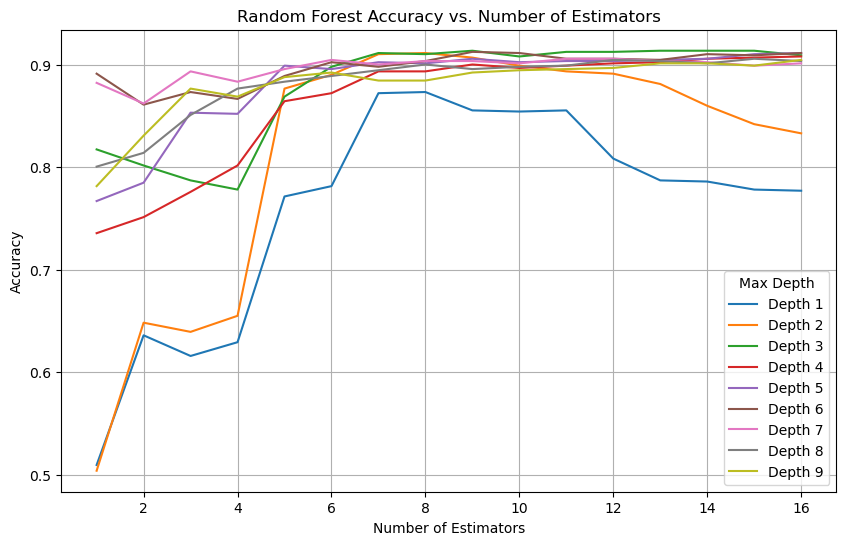

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
for depth in results_df['max_depth'].unique():
    subset = results_df[results_df['max_depth'] == depth]
    plt.plot(subset['n_estimators'], subset['Accuracy'], label=f"Depth {depth}")

# Add labels and legend
plt.title("Random Forest Accuracy vs. Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.legend(title="Max Depth")
plt.grid(True)
plt.show()

Fitting Gradient Boosting Classifier

In [32]:
# Train Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=51, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
boost_accuracy = accuracy_score(y_test, y_pred)
boost_error = 1 - boost_accuracy
print(f"Accuracy: {boost_accuracy}")
print(f"Boosting Test Error: {boost_error}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9025755879059351
Boosting Test Error: 0.09742441209406494

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       447
           1       0.95      0.85      0.90       446

    accuracy                           0.90       893
   macro avg       0.91      0.90      0.90       893
weighted avg       0.91      0.90      0.90       893



Fitting Gradient Boosting on a range of estimators and depths to find max accuracy

In [33]:
results2 = []
for n_estimators in range(1, 17):
    for max_depth in range(1, 10):
        model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results2.append({
            "Model": "GradientBoosting",
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "Accuracy": accuracy
        })

Visual of Gradient Boosting accuracy compared to number of estimators and depth

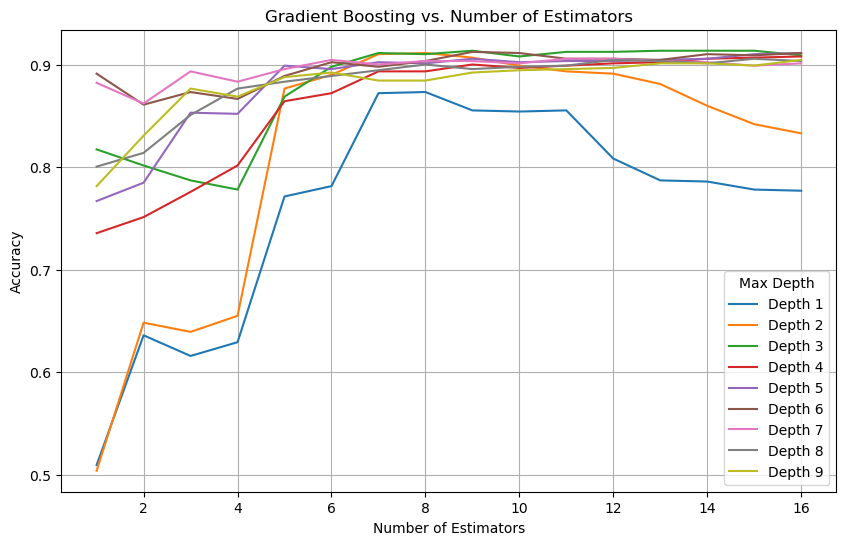

In [36]:
plt.figure(figsize=(10, 6))
for depth in results_df['max_depth'].unique():
    subset = results_df[results_df['max_depth'] == depth]
    plt.plot(subset['n_estimators'], subset['Accuracy'], label=f"Depth {depth}")

# Add labels and legend
plt.title("Gradient Boosting vs. Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.legend(title="Max Depth")
plt.grid(True)
plt.show()

### Conclusion

After fitting LDA, QDA, Logistic Regression, Bagging, Boosting, and Random Forest, we found Boosting and RF to give the highest accuracy. We then ran both models on a range of number of estimators and depth to find the ideal model that maximizes accuracy. Both gradient boosting and random forest achieved roughly the same accuracy with Random Forest at (n = 10, depth = 9) and (n = 2, depth = 5) achieveing 0.938 accuracy and Gradient Boosting at (n = 11, depth = 7) and (n = 1, depth = 8) achieving 0.938 accuracy as well. This suggests that there may be few highly determinant factors that predict a majority of team outcomes. A large proportion of our final selected features were based on team-to-team interactions for each game indicating how basketball game outcomes as a highly interactive sport are very dependent on the opponent.